In [65]:
import torch
from torch_geometric.datasets import Planetoid, KarateClub
from torch_geometric.transforms import NormalizeFeatures
import torch.nn.functional as F
torch.set_printoptions(threshold=5000)

In [66]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [67]:
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [69]:
from torch_geometric.nn import GCNConv, TAGConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = TAGConv(dataset.num_features, hidden_channels)
        self.conv2 = TAGConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): TAGConv(1433, 16, K=3)
  (conv2): TAGConv(16, 7, K=3)
)


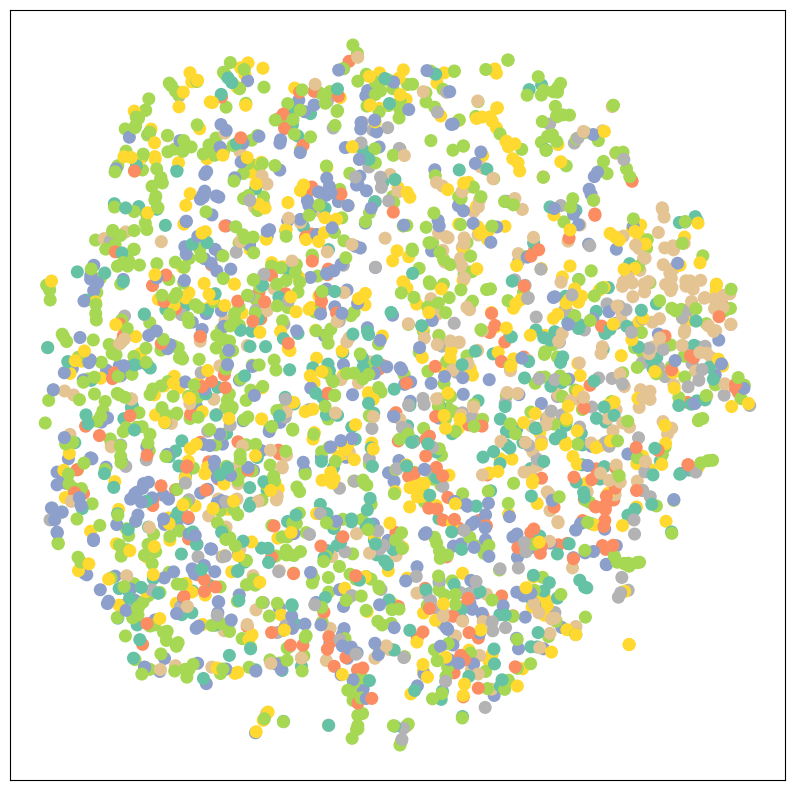

In [49]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [70]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
      return test_acc

In [71]:
for epoch in range(1, 101):
    loss = train()
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 001, Loss: 1.9459, Val: 0.3740, Test: 0.3750
Epoch: 002, Loss: 1.9288, Val: 0.6260, Test: 0.6120
Epoch: 003, Loss: 1.8953, Val: 0.5520, Test: 0.5540
Epoch: 004, Loss: 1.8572, Val: 0.4560, Test: 0.4380
Epoch: 005, Loss: 1.8109, Val: 0.4120, Test: 0.4180
Epoch: 006, Loss: 1.7606, Val: 0.4340, Test: 0.4350
Epoch: 007, Loss: 1.7039, Val: 0.4900, Test: 0.4750
Epoch: 008, Loss: 1.6367, Val: 0.5320, Test: 0.5220
Epoch: 009, Loss: 1.5554, Val: 0.5640, Test: 0.5700
Epoch: 010, Loss: 1.5107, Val: 0.6080, Test: 0.6240
Epoch: 011, Loss: 1.4223, Val: 0.6500, Test: 0.6530
Epoch: 012, Loss: 1.3585, Val: 0.6740, Test: 0.6820
Epoch: 013, Loss: 1.2524, Val: 0.7060, Test: 0.7020
Epoch: 014, Loss: 1.2064, Val: 0.7280, Test: 0.7150
Epoch: 015, Loss: 1.1196, Val: 0.7380, Test: 0.7320
Epoch: 016, Loss: 1.0345, Val: 0.7440, Test: 0.7390
Epoch: 017, Loss: 0.9948, Val: 0.7540, Test: 0.7510
Epoch: 018, Loss: 0.8807, Val: 0.7600, Test: 0.7670
Epoch: 019, Loss: 0.8511, Val: 0.7740, Test: 0.7680
Epoch: 020, 

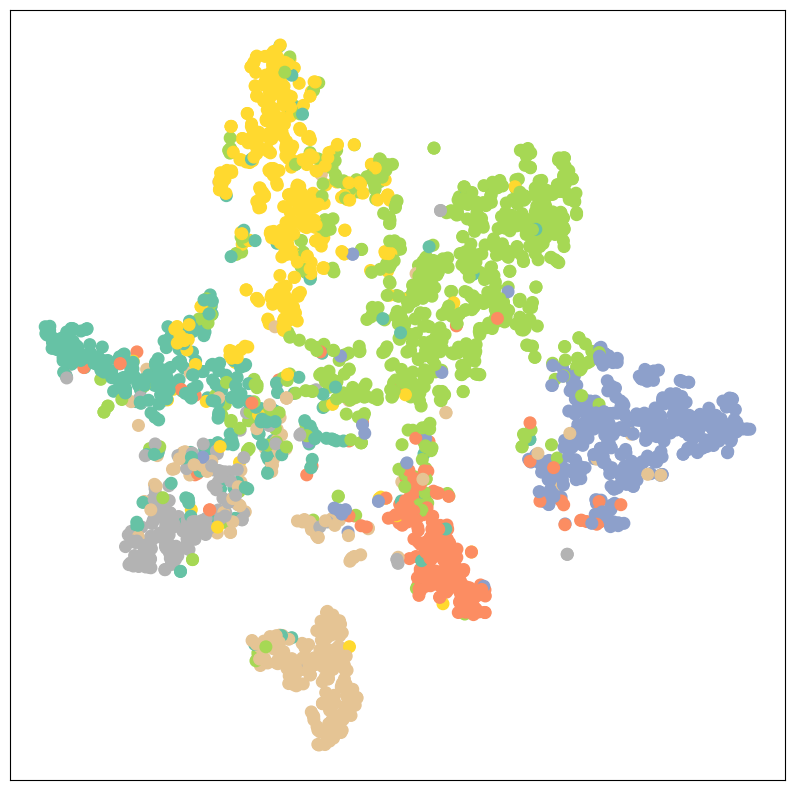

In [52]:
out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [72]:
from torch_geometric.explain import Explainer, GNNExplainer, GraphMaskExplainer

explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=100),
    explanation_type='model',
    node_mask_type='object',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
)

# explainer = Explainer(
#     model=model,
#     algorithm=GraphMaskExplainer(2, epochs=5),
#     explanation_type='model',
#     node_mask_type='attributes',
#     edge_mask_type='object',
#     model_config=dict(
#         mode='multiclass_classification',
#         task_level='node',
#         return_type='log_probs',
#     ),
# )

In [73]:
node_index = 10 # which node index to explain
explanation = explainer(data.x, data.edge_index, index=node_index)

In [74]:
print(data.edge_index.shape)

# explanation.visualize_feature_importance("img/feature_importance.png", top_k=10)
explanation.visualize_graph("img/graph_vis.png")

torch.Size([2, 10556])


In [79]:
import numpy as np

edge_weight = explanation.edge_mask
edge_index = data.edge_index

mask = edge_weight > 0.3
edge_index = edge_index[:, mask]
edge_weight = edge_weight[mask]

# attr = [attr for attr in dir(explanation) if not attr.startswith('_')]
# print(attr)
# print([key for key, val in vars(explanation)["_store"].items()])

print(edge_index.shape)
print(np.unique(edge_index.numpy()))

torch.Size([2, 11])
[  10  476  852 1072 1140 1800 2545]


In [20]:
node_weight = explanation.node_mask
node_index = data.node_index

AttributeError: 'GlobalStorage' object has no attribute 'node_index'

In [136]:
def track_edge_frequencies(data, explainer):
    edge_frequency = {}

    for i in range(30):
        print("here")
        explanation = explainer(data.x, data.edge_index, index=i)
        
        edge_weight = explanation.edge_mask
        edge_index = data.edge_index

        significant_edge_mask = edge_weight > 0.5
        significant_edge_index = edge_index[:, significant_edge_mask]

        for j in range(significant_edge_index.shape[1]):
            edge = tuple(sorted((significant_edge_index[0, j].item(), significant_edge_index[1, j].item())))
            
            if edge in edge_frequency:
                edge_frequency[edge] += 1
            else:
                edge_frequency[edge] = 1

    return edge_frequency

In [149]:
freq = track_edge_frequencies(data, explainer)

def get_top_edges(edge_frequency, top_n=10):
    sorted_edges = sorted(edge_frequency.items(), key=lambda item: item[1], reverse=True)
    top_edges = sorted_edges[:top_n]
    return top_edges

print(get_top_edges(freq))

here
here
here
here
here
here
here
here
here
here


KeyboardInterrupt: 

In [150]:
def process_subset(data, indices, explainer):
    edge_frequency = {}
    for i in indices:
        print("here")
        explanation = explainer(data.x, data.edge_index, index=i)
        edge_weight = explanation.edge_mask
        edge_index = data.edge_index

        significant_edge_mask = edge_weight > 0.5
        significant_edge_index = edge_index[:, significant_edge_mask]

        for j in range(significant_edge_index.shape[1]):
            edge = tuple(sorted((significant_edge_index[0, j].item(), significant_edge_index[1, j].item())))
            
            if edge in edge_frequency:
                edge_frequency[edge] += 1
            else:
                edge_frequency[edge] = 1
    return edge_frequency

In [151]:
from multiprocessing import Pool

num_processes = 4  # Adjust this based on your CPU cores
index_ranges = torch.tensor_split(torch.Tensor(range(30)), num_processes)

def parallel_processing(data, explainer):
    with Pool(processes=num_processes) as pool:
        results = pool.starmap(process_subset, [(data, indices, explainer) for indices in index_ranges])
    return results

In [152]:
def merge_results(results):
    final_edge_frequency = {}
    for result in results:
        for edge, count in result.items():
            if edge in final_edge_frequency:
                final_edge_frequency[edge] += count
            else:
                final_edge_frequency[edge] = 1
    return final_edge_frequency


freq = parallel_processing(data, explainer)
res = merge_results(freq)

print(get_top_edges(res))

Process SpawnPoolWorker-19:
Process SpawnPoolWorker-17:
Process SpawnPoolWorker-18:
Process SpawnPoolWorker-20:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.11/3.11.8/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/homebrew/Cellar/python@3.11/3.11.8/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/homebrew/Cellar/python@3.11/3.11.8/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/opt/homebrew/Cellar/python@3.11/3.11.8/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
     

KeyboardInterrupt: 

Explanation(node_mask=[7, 1433], edge_mask=[8], prediction=[7, 7], target=[7], index=[1], x=[7, 1433], edge_index=[2, 8])


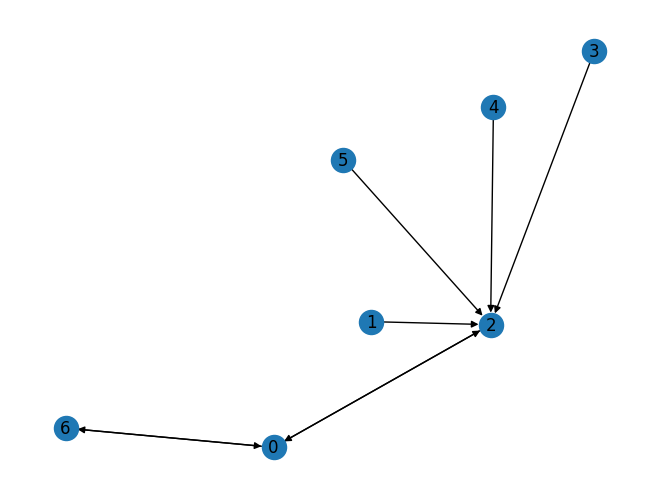

In [138]:
from torch_geometric.utils.convert import to_networkx
import networkx as nx

print(explanation.get_explanation_subgraph())
node_mask = to_networkx(explanation.get_explanation_subgraph())
nx.draw(node_mask, with_labels = True)

In [145]:
def _visualize_graph_via_graphviz(
    edge_index,
    edge_weight,
    path = None,
    node_labels = None
):
    import graphviz

    suffix = path.split('.')[-1] if path is not None else None
    g = graphviz.Digraph('graph', format=suffix)
    g.attr('node', shape='circle', fontsize='11pt')

    for node in edge_index.view(-1).unique().tolist():
        g.node(str(node) if node_labels is None else node_labels[node])

    for (src, dst), w in zip(edge_index.t().tolist(), edge_weight.tolist()):
        hex_color = hex(255 - round(255 * w))[2:]
        hex_color = f'{hex_color}0' if len(hex_color) == 1 else hex_color
        if node_labels is not None:
            src = node_labels[src]
            dst = node_labels[dst]
        g.edge(str(src), str(dst), color=f'#{hex_color}{hex_color}{hex_color}')

    if path is not None:
        path = '.'.join(path.split('.')[:-1])
        g.render(path, cleanup=True)
    else:
        g.view()

    return g

In [146]:
_visualize_graph_via_graphviz(explanation.get_explanation_subgraph().edge_index, explanation.get_explanation_subgraph().edge_mask)

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [21]:
print(dataset.num_nodes)

AttributeError: 'Planetoid' object has no attribute 'num_nodes'